<a href="https://colab.research.google.com/github/ShimaGhandriz/SwinTransformer-Tumor-Detection/blob/main/SwinT_Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 3.8 MB/s eta 0:00:00


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [3]:
!pip install huggingface_hub

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
# Import The Libraries

import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

from glob import glob
from google.colab import files
import os
from zipfile import ZipFile



In [6]:
import torch
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from datasets import load_dataset
from datasets import load_metric

import random

In [7]:

#Download the dataset

files.upload()
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection


Saving kaggle.json to kaggle.json
 46% 7.00M/15.1M [00:00<00:00, 71.4MB/s]
100% 15.1M/15.1M [00:00<00:00, 86.0MB/s]


In [8]:
with ZipFile('/content/brain-mri-images-for-brain-tumor-detection.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory // mode read r/ w a
   zipObj.extractall()

In [9]:
# Load the data

dataset = load_dataset("imagefolder", data_dir="/content/brain_tumor_dataset")

Resolving data files:   0%|          | 0/253 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
train_ds = dataset['train'].train_test_split(test_size=0.2, seed=30, shuffle= True)
train_data = train_ds['train']
test_data = train_ds['test']


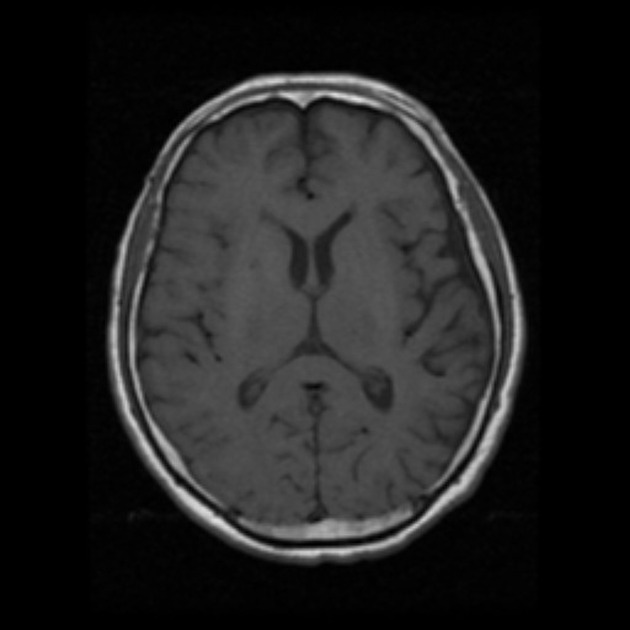

In [11]:
train_data[0]['image']

In [12]:
label = list(set(train_data['label']))
id2label = {id:label for id, label in enumerate(label)}
label2id = {label:id for id,label in id2label.items()}
print(id2label, label2id)

{0: 0, 1: 1} {0: 0, 1: 1}


In [13]:
# Preprocessing  the data

from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [14]:
# Apply transformations

from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [15]:
# Set the transforms
train_data.set_transform(train_transforms)
# val_ds.set_transform(val_transforms)
test_data.set_transform(val_transforms)

In [16]:

metric = load_metric("accuracy")
def compute_metrics(p):
  # function which calculates accuracy for a certain set of predictions
  return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-16-b92f4d5cca0b>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [17]:
from transformers import SwinForImageClassification, Trainer, TrainingArguments

model_name= 'microsoft/swin-base-patch4-window7-224'

# initialzing the model
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=len(label),
    id2label={str(i): c for i, c in enumerate(label)},
    label2id={c: str(i) for i, c in enumerate(label)},
    ignore_mismatched_sizes = True,
)


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def collate_fn(batch):
  #data collator
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [23]:
from transformers import Trainer, TrainingArguments

batch_size = 16
# Defining training arguments (set push_to_hub to false if you don't want to upload it to HuggingFace's model hub)
training_args = TrainingArguments(
    f"Brain-Tumor-Detection",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)



In [24]:
# Instantiate the Trainer object

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=processor,
)

In [25]:
# Train and save results
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.439535,0.666667
1,No log,0.281703,0.901961
2,No log,0.135371,0.960784
4,0.399400,0.094555,0.980392


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =       4.62
  total_flos               = 68295225GF
  train_loss               =     0.3285
  train_runtime            = 0:01:36.44
  train_samples_per_second =     10.473
  train_steps_per_second   =      0.156


In [26]:
# Evaluate on validation set
metrics = trainer.evaluate(test_data)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       4.62
  eval_accuracy           =     0.9804
  eval_loss               =     0.0956
  eval_runtime            = 0:00:00.91
  eval_samples_per_second =     56.022
  eval_steps_per_second   =      4.394
